So far we have been looking at some of the basic tools provided with OMUSE. These tools are generally useful but mainly meant to ease working with *community* codes. *Community* codes form the core of the OMUSE framework and are the functional components to evolve oceanographic models in time or calculate properties of the physical models.

*Community* codes are existing and newly developed applications, implemented in C/C++ or Fortran. The OMUSE framework provides an interface to these codes so that you can interact with every code in a standard way.



To start a code one must import the interface class for a code (again we start with some useful imports):

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from omuse.units import units, constants
from amuse.io import write_set_to_file


from omuse.community.qgmodel.interface import QGmodel

The interface to a *Community* code is implemented as a class with a name based on the name of the original application. In this case we will use QGmodel, a quasi geostrophic solver for a square domain. We can *instantiate* the QG model at this point:

In [2]:
q=QGmodel()

At this point, the code is running, but waiting for further input, for example we can query (and set) its parameters (these will be different for different codes). Note that the parameters carry units:

In [3]:
print q.parameters

A_H: 100.0 m**2 * s**-1
Lx: 4000000.0 m
Ly: 4000000.0 m
Nm: 1
Nx: 0
Ny: 0
R_H: 0.0 s**-1
T: 86400.0 s
begin_time: 0.0 s
beta0: 1.8616e-11 m**-1 * s**-1
boundary_east: free_slip
boundary_north: free_slip
boundary_south: free_slip
boundary_west: free_slip
dt: 3600.0 s
dx: 10000.0 m
dy: 10000.0 m
e111: 0.0
err_tol: 1e-06
interface_wind: False
lambda0: 0.0 m**-1
lambda1: 2e-05 m**-1
max_it: 20000
ocean_depth: 4000.0 m
phi1z0: 1.41421356237
position_x: 0.0 m
position_y: 0.0 m
raw_parameter: 1.0
relax_coef: 1.7
rho: 1000.0 kg * m**-3
robert_asselin_alpha: 0.1
savecounter: 48
tau: 0.05 Pa
timestep_method: leapfrog
wind_sigma: -99.0
x_boundary_conditions: ['free_slip' 'free_slip']
y_boundary_conditions: ['free_slip' 'free_slip']



We can get information on the parameters using `print q.parameters.__doc__`. 

A simulation code in OMUSE typically supports particle collections or grids, these are used to make the simulation state accessible, and to receive e.g. external forcings.

In [4]:
print q.grid
print q.forcings

RegularGrid (401 x 401 x 1) (dpsi_dt, psi, psi_prev, x, y)
RegularGrid (401 x 401) (tau_x, x, y)


Note that the simulation state `grid` is 3D, the third dimension describes the different modes (by default the number of modes is Nm=1, so the model is purely barotropic. Here we only use Nm=1). The model starts out initialized to zero:

In [5]:
print'min:', q.grid.psi.min(),'max:',q.grid.psi.max()

min: 0.0 m**2 * s**-1 max: 0.0 m**2 * s**-1


We can evolve the model forward in time using `evolve_model`, but first let's impose some wind stress:

In [6]:
q.forcings.tau_x= (0.15 | units.Pa)*numpy.sin(numpy.pi*q.forcings.y/q.parameters.Ly)

In [7]:
q.evolve_model(1 | units.day)
print "evolved untile time ", q.model_time

evolved untile time  86400.0 s


After evolving we can save the data or plot it if we want.

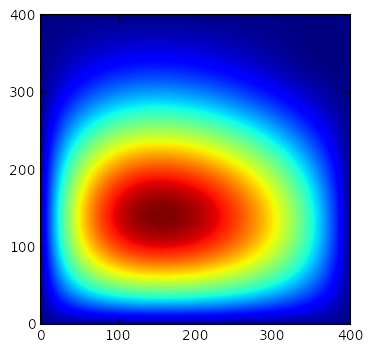

In [8]:
pyplot.imshow(numpy.transpose ( q.grid[:,:,0].psi.value_in(units.Sv/units.km)), origin='lower')
write_set_to_file(q.grid,"qgmodel_grid","amuse")


We can start any number of instances of the `QGmodel` code, or any other code, and they can be evolved independently. 
When we are done with a particular instance of the code, we can stop the code (freeing the memory and releasing the cores for something else). After stopping the code we cannot interact with it any longer and requesting any grid attributes of the code will result in an error. 

In [10]:
q.stop()

Code interaction sequence
-------------------------

All interaction with codes in omuse (and amuse) follow the same general sequence. An instance of the code interface is created, parameters controlling the code are set, particles are added or grids filled, the model is evolved, data is retrieved and the code is stopped. So, for illustration let us calculate a completely different problem, namely the evolution of a small star cluster:

In [11]:
from amuse.community.bhtree.interface import BHTree
from amuse.units import nbody_system
from amuse.ic.plummer import new_plummer_model
code = BHTree()                                                   # 1 code is created and started
code.parameters.epsilon_squared = (0.01 | nbody_system.length)**2 # 2 parameters are set
code.particles.add_particles(new_plummer_model(100))              # 3 particles are added
code.evolve_model(1 | nbody_system.time)                          # 4 model is evolved in the code
write_set_to_file(code.particles, 'evolved_cluster.hdf5', 'hdf5') # 5 data is retrieved
print 'evolved until',code.model_time                            
code.stop()                                                       # 6 code is stopped

evolved until 1.0 time


Some steps are optional, for example in a lot of codes you do not need to set any parameters if you have a simple problem. Others are critical, for example, you'll need to add particles to the code or else it will not evolve anything and some codes will return with an error. 